# Convolutional Variational Autoencoder for Handwritten Digit 
## This homework is done in partnership by:
### Devansh Batra (batra17@purdue.edu)
### Lakshay Vohra (lvohra@purdue.edu)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it. 

In [2]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows, img_cols, 1) 
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows, img_cols, 1) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255. 
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 28, 28, 1)
60000 train samples, 10000 test samples


## The model

In [4]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2
strides = 2
padding = 'same'

### Fill in this block to build the encoder model

In [9]:
# build encoder model
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs

x = layers.Conv2D(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           strides=2,
                           padding='same', name='conv2d')(x)

shape=x.shape

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [11]:
# use reparameterization trick to push the sampling out as input instead of sampling from Q(z|X)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps
       
    Arguments:
        args:       mean and log of variance of Q(z|X)

    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    
    return mean + K.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 6272)         0           ['conv2d[0][0]']                 
                                                                                                  
 dense_2 (Dense)                (None, 16)           100368      ['flatten[0][0]']                
                                                                                            

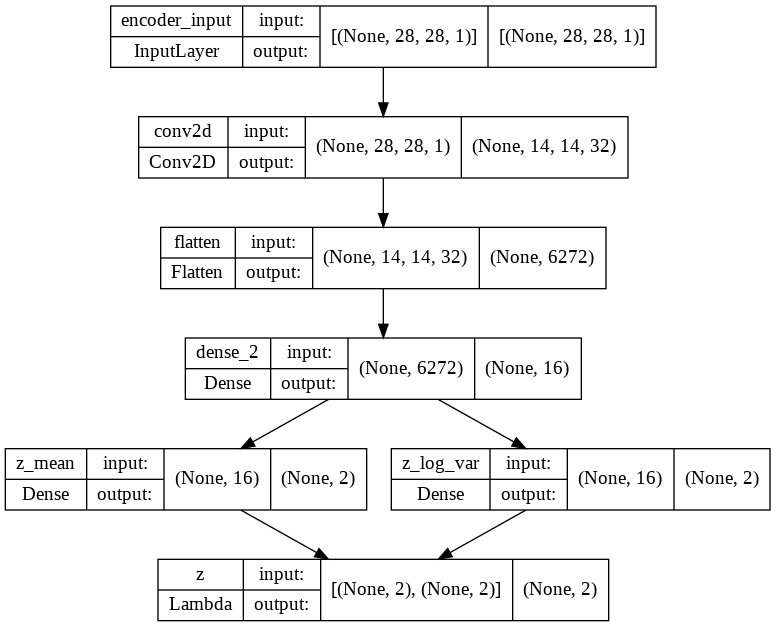

In [12]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                48        
                                                                 
 dense_4 (Dense)             (None, 6272)              106624    
                                                                 
 reshape (Reshape)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       9248      
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                     

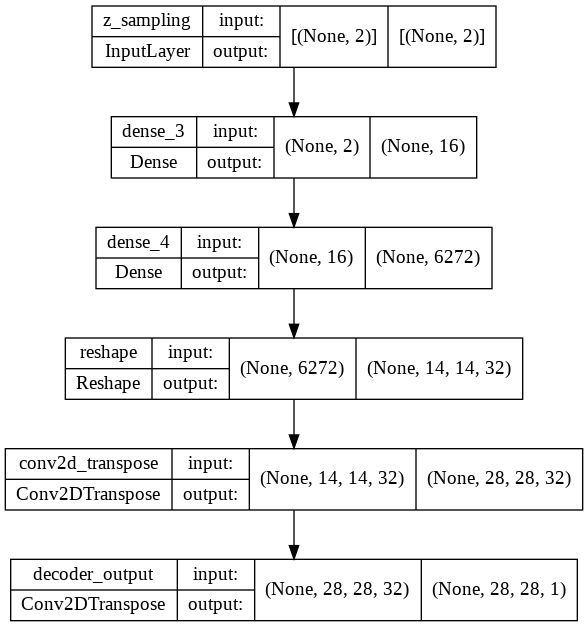

In [13]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

x = layers.Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           strides=2,
                           padding='same')(x)

outputs = layers.Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

In [14]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_rows*img_cols
kl_loss =  -0.5 *K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

optimizer = keras.optimizers.RMSprop(0.0005, decay=1e-6)
vae.compile(optimizer=optimizer)

In [15]:
BATCH = 100
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
600/600 [==============================] - 64s 104ms/step - loss: 198.3041 - val_loss: 176.0918
Epoch 2/40
600/600 [==============================] - 62s 104ms/step - loss: 172.7433 - val_loss: 169.9817
Epoch 3/40
600/600 [==============================] - 63s 105ms/step - loss: 167.7200 - val_loss: 167.3430
Epoch 4/40
600/600 [==============================] - 62s 104ms/step - loss: 164.4475 - val_loss: 162.7481
Epoch 5/40
600/600 [==============================] - 62s 103ms/step - loss: 162.0449 - val_loss: 160.8505
Epoch 6/40
600/600 [==============================] - 62s 104ms/step - loss: 160.1107 - val_loss: 159.5565
Epoch 7/40
600/600 [==============================] - 63s 104ms/step - loss: 158.5174 - val_loss: 158.2260
Epoch 8/40
600/600 [==============================] - 63s 105ms/step - loss: 157.2548 - val_loss: 156.9020
Epoch 9/40
600/600 [==============================] - 62s 104ms/step - loss: 156.2560 - val_loss: 156.0128
Epoch 10/40
600/600 [================

In [16]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 15x15 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

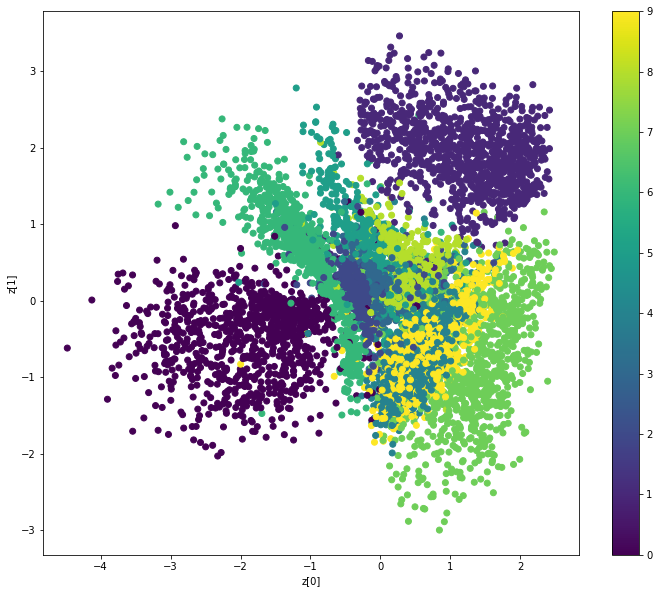

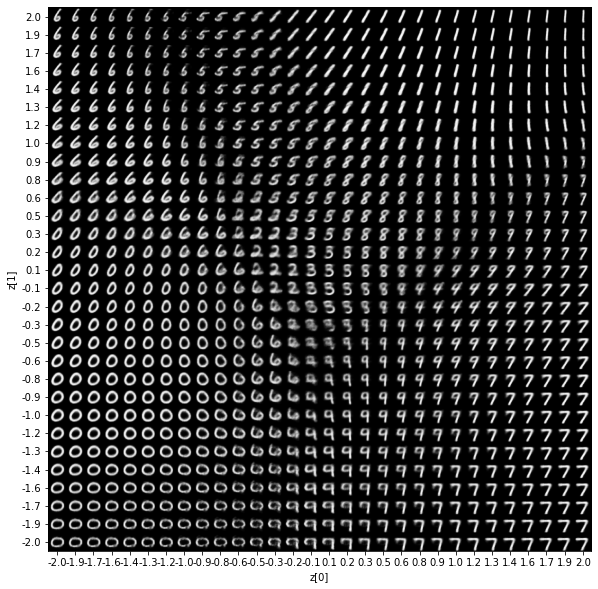

In [17]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_cnn")